### Plant Image Classification

##### Objective: Classify images as either Rafinesquia neomexicana or Calycoseris wrightii, first using lateral view and then using dorsal view. Lateral view is expected to be easier to classify due to C. wrightii having glandular hairs on upper-stem and phyllaries. 

In [25]:
import pandas as pd

In [26]:
# Read in C. wrightii and R. neomexicana annotated data 
rn_data = pd.read_csv('/home/gradyerin/blue_bsc4892/gradyerin/ai-taxonomist/data/processed/annotated-records/rn-pulled-annotations_first220.csv')
cw_data = pd.read_csv('/home/gradyerin/blue_bsc4892/gradyerin/ai-taxonomist/data/processed/annotated-records/cw-pulled-annotations_all.csv')

# Display the first few rows of the DataFrame to verify
filtered_rn_data = rn_data[rn_data['usable'] == 1]
filtered_cw_data = cw_data[cw_data['usable'] == 1] # different because excel formatting sucks
print(filtered_cw_data.head())

                   obs_id  usable ourSpeciesID      dorsalImage  \
0   observation_103018287       1           CW  103018287_1.jpg   
1    observation_10445512       1           CW   10445512_2.jpg   
3    observation_10722929       1           CW   10722929_4.jpg   
8   observation_108043537       1           CW  108043537_1.jpg   
11  observation_108926666       1           CW  108926666_2.jpg   

       lateralImage  Possible  
0   103018287_2.jpg       0.0  
1    10445512_1.jpg       0.0  
3    10722929_3.jpg       0.0  
8   108043537_3.jpg       0.0  
11  108926666_3.jpg       0.0  


In [27]:
#Check lengths of dfs
rn_l = len(filtered_rn_data)
cw_l = len(filtered_cw_data)
print(rn_l)
print(cw_l)

221
219


### Classification: Lateral Images

In [28]:
import os
import shutil
import tensorflow as tf
import keras
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

from tensorflow.keras.applications.densenet import decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

### Image Pre-processing

In [29]:
import os

# Path to the directory containing your images
base_dir = '/home/gradyerin/blue_bsc4892/gradyerin/ai-taxonomist/image_sets/lateral-images'

# Get the names of subdirectories (class labels)
class_labels = os.listdir(base_dir)

# Create a dictionary to map class names to numerical labels
label_map = {class_label: idx for idx, class_label in enumerate(class_labels)}

# Iterate through each class directory
for class_label in class_labels:
    class_dir = os.path.join(base_dir, class_label)
    
    # Iterate through each image in the class directory
    for image_file in os.listdir(class_dir):
        # Assign the corresponding label to the image
        label = label_map[class_label]
        print(f"Image: {image_file}, Label: {label}")


Image: 110231989_2.jpg, Label: 0
Image: 10370082_1.jpg, Label: 0
Image: 10304992_2.jpg, Label: 0
Image: 109340106_2.jpg, Label: 0
Image: 10478204_4.jpg, Label: 0
Image: 111053022_1.jpg, Label: 0
Image: 10370155_1.jpg, Label: 0
Image: 108075691_2.jpg, Label: 0
Image: 107655161_1.jpg, Label: 0
Image: 10991144_2.jpg, Label: 0
Image: 150762534_4.jpg, Label: 0
Image: 150715416_2.jpg, Label: 0
Image: 107496854_1.jpg, Label: 0
Image: 117652134_2.jpg, Label: 0
Image: 110302266_1.jpg, Label: 0
Image: 10577115_2.jpg, Label: 0
Image: 142760139_1.jpg, Label: 0
Image: 148418736_2.jpg, Label: 0
Image: 109586936_3.jpg, Label: 0
Image: 147744124_2.jpg, Label: 0
Image: 108279711_2.jpg, Label: 0
Image: 10304856_3.jpg, Label: 0
Image: 109116797_2.jpg, Label: 0
Image: 108871537_1.jpg, Label: 0
Image: 147496357_1.jpg, Label: 0
Image: 107763752_7.jpg, Label: 0
Image: 12112872_2.jpg, Label: 0
Image: 10515187_1.jpg, Label: 0
Image: 148452582_2.jpg, Label: 0
Image: 148328021_1.jpg, Label: 0
Image: 108630221_2.

### Loading the model

In [30]:
#Load DenseNet model without the top (last) layer
model = tf.keras.applications.densenet.DenseNet121(
    include_top=False, weights='imagenet')

#model.summary()

In [31]:
#Freeze the weights
model.trainable = False

In [32]:
#Set values for managing data and training

# Input image dimensions, etc.
resized_height = 224
resized_width = 224
num_channel = 3
num_classes = 14
batch_size = 128

# Paths to images. These are too large to keep in the git repo. 
# Details of getting images ready are at the end of the notebook.
base_dir = '/home/gradyerin/blue_bsc4892/gradyerin/ai-taxonomist/image_sets/'
image_dir = os.path.join(base_dir, 'lateral-images')

In [33]:
#Add new layers 

inputs = keras.Input(shape=(resized_height, resized_width, num_channel))
# Separately from setting trainable on the model, we set training to False 
x = model(inputs, training=False)
# A Dense classifier with a single unit (binary classification)
flatten = keras.layers.Flatten()(x)
dense = keras.layers.Dense(1)(flatten)
outputs = Dense(1,activation='sigmoid')(dense)

model = keras.Model(inputs, outputs)

In [34]:
# Compile the new model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#LOADING DATA

In [35]:
# Note using rgb to get 3 color channels as needed as input for DenseNet
train_images = image_dataset_from_directory(
    image_dir, labels='inferred', label_mode='binary',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=42, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

Found 432 files belonging to 2 classes.
Using 346 files for training.


In [36]:
valid_images = image_dataset_from_directory(
    image_dir, labels='inferred', label_mode='binary',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=42, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

Found 432 files belonging to 2 classes.
Using 86 files for validation.


In [37]:
#look at size of dataset
train_images

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

['cw-images', 'rn-images']
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


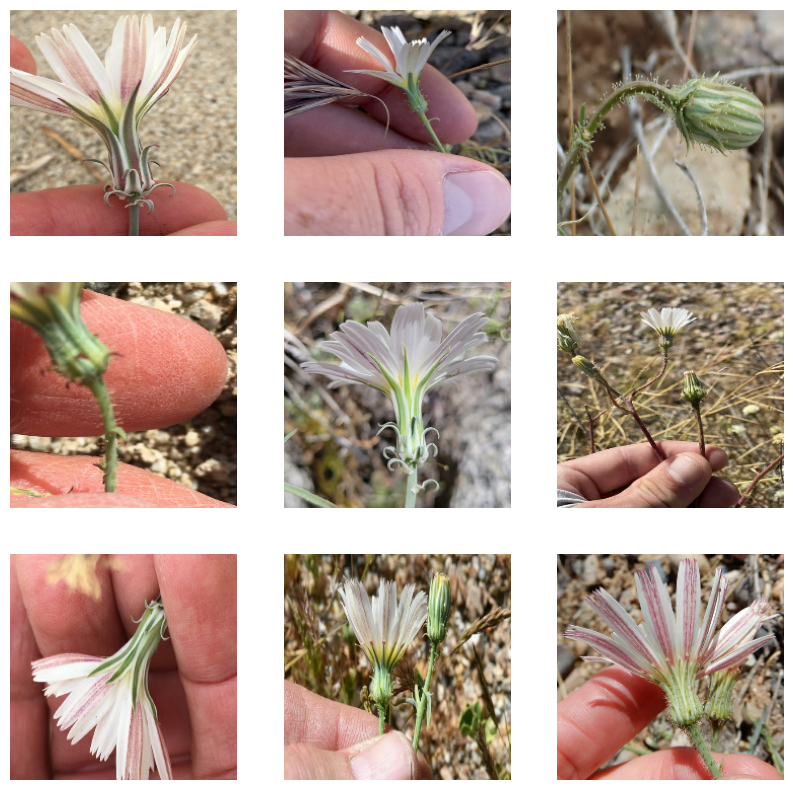

In [39]:
#LOOK AT SOME OF THE LOADED IMAGES

# Note that the images have been loaded with 3 color channels!
class_names = train_images.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")
    print(images[i].shape)

In [40]:
#FIT THE MODEL

history = model.fit(train_images, batch_size=batch_size, epochs=50, verbose=1, validation_data=valid_images)

Epoch 1/50
3/3 [==============================] - 7s 1s/step - loss: 19.8063 - accuracy: 0.4971 - val_loss: 10.5357 - val_accuracy: 0.5116
Epoch 2/50
3/3 [==============================] - 2s 214ms/step - loss: 12.2536 - accuracy: 0.5000 - val_loss: 4.2056 - val_accuracy: 0.5349
Epoch 3/50
3/3 [==============================] - 3s 526ms/step - loss: 4.1745 - accuracy: 0.6069 - val_loss: 2.8274 - val_accuracy: 0.5465
Epoch 4/50
3/3 [==============================] - 3s 811ms/step - loss: 2.6160 - accuracy: 0.6734 - val_loss: 2.6611 - val_accuracy: 0.5581
Epoch 5/50
3/3 [==============================] - 3s 177ms/step - loss: 1.8890 - accuracy: 0.7543 - val_loss: 3.3545 - val_accuracy: 0.5465
Epoch 6/50
3/3 [==============================] - 2s 310ms/step - loss: 1.3785 - accuracy: 0.7601 - val_loss: 3.7879 - val_accuracy: 0.5930
Epoch 7/50
3/3 [==============================] - 3s 563ms/step - loss: 0.6903 - accuracy: 0.8728 - val_loss: 4.0774 - val_accuracy: 0.5698
Epoch 8/50
3/3 [====